# Problem Statement

In this competition provided the data gathered from one of the top apparel brands in India. Provided the details concerning category, score, and presence in the store,we are challenged  to come up with a Classification algorithm to predict the popularity level of the merchandise.

Source data: https://www.machinehack.com/hackathons/merchandise_popularity_prediction_challenge/overview

# Performane Metrics Used

1.Confusion Matrix

2.Log Loss

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn import metrics
from sklearn.metrics import log_loss,confusion_matrix
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import optuna
from sklearn.calibration import CalibratedClassifierCV 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,CategoricalNB,ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [31]:
#reading the data 
train=pd.read_csv("popularity/Train.csv")
print("total number of rows :",train.shape[0])
print("columns list :",train.columns.values)
train.head(10)

total number of rows : 18208
columns list : ['Store_Ratio' 'Basket_Ratio' 'Category_1' 'Store_Score' 'Category_2'
 'Store_Presence' 'Score_1' 'Score_2' 'Score_3' 'Score_4' 'time'
 'popularity']


,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time,popularity
0,0.407,0.00380,2,-35.865,1,0.9920,0.94400,0.0988,0.1100,113.911,189125,4
1,0.234,0.10500,0,-19.884,1,0.9440,0.90000,0.1290,0.0382,76.332,186513,4
2,0.668,0.72600,9,-7.512,1,0.0387,0.00000,0.1340,0.4530,124.075,172143,4
3,0.184,0.00561,4,-34.357,1,0.8490,0.93100,0.1110,0.0641,79.037,184000,5
4,0.231,0.13100,6,-22.842,1,0.9370,0.00000,0.1090,0.0677,109.560,186507,3
5,0.756,0.60900,3,-7.927,1,0.2170,0.00474,0.0960,0.5370,117.023,155720,4
6,0.398,0.03360,10,-30.369,1,0.9960,0.96200,0.1300,0.6120,72.166,134500,4
7,0.717,0.69900,5,-5.665,0,0.2230,0.00000,0.1390,0.6890,100.147,186600,4
8,0.419,0.57400,4,-12.221,0,0.1020,0.46200,0.8950,0.3450,129.260,685880,4
9,0.705,0.22100,3,-11.474,0,0.9380,0.90600,0.1110,0.3840,84.962,143131,4


In [4]:
#checking for null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Store_Ratio     18208 non-null  float64
 1   Basket_Ratio    18208 non-null  float64
 2   Category_1      18208 non-null  int64  
 3   Store_Score     18208 non-null  float64
 4   Category_2      18208 non-null  int64  
 5   Store_Presence  18208 non-null  float64
 6   Score_1         18208 non-null  float64
 7   Score_2         18208 non-null  float64
 8   Score_3         18208 non-null  float64
 9   Score_4         18208 non-null  float64
 10  time            18208 non-null  int64  
 11  popularity      18208 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.7 MB


There are no null values

In [4]:
len(train["Category_1"].value_counts())

12

there are 12 unique values in Category_1

In [6]:
train["Category_2"].value_counts()

1    11808
0     6400
Name: Category_2, dtype: int64

In [7]:
train["popularity"].value_counts()

4    15231
3     2166
5      472
1      323
0       16
Name: popularity, dtype: int64

This is an imbalanced dataset


In [3]:
train.corr()

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time,popularity
Store_Ratio,1.000000,0.465598,0.040335,0.599820,-0.102391,-0.471475,-0.454113,-0.039416,0.620874,0.119472,-0.063763,0.232888
Basket_Ratio,0.465598,1.000000,0.051739,0.826055,-0.114843,-0.821807,-0.612220,0.275749,0.527086,0.253789,0.101478,0.200988
Category_1,0.040335,0.051739,1.000000,0.042988,-0.139914,-0.046474,-0.028973,0.019738,0.036477,0.003057,-0.012886,0.003716
Store_Score,0.599820,0.826055,0.042988,1.000000,-0.085984,-0.723449,-0.726385,0.145093,0.516937,0.263739,0.080659,0.204896
Category_2,-0.102391,-0.114843,-0.139914,-0.085984,1.000000,0.104456,0.020086,-0.036357,-0.043944,-0.046058,-0.009798,-0.034565
Store_Presence,-0.471475,-0.821807,-0.046474,-0.723449,0.104456,1.000000,0.571346,-0.190961,-0.431723,-0.222663,-0.072484,-0.195113
Score_1,-0.454113,-0.612220,-0.028973,-0.726385,0.020086,0.571346,1.000000,-0.104020,-0.474795,-0.201852,-0.113319,-0.163667
Score_2,-0.039416,0.275749,0.019738,0.145093,-0.036357,-0.190961,-0.104020,1.000000,0.033445,0.019435,-0.002480,0.001737
Score_3,0.620874,0.527086,0.036477,0.516937,-0.043944,-0.431723,-0.474795,0.033445,1.000000,0.181573,0.009258,0.176765
Score_4,0.119472,0.253789,0.003057,0.263739,-0.046058,-0.222663,-0.201852,0.019435,0.181573,1.000000,0.026966,0.043677


There is no multicolinearity in the features

In [32]:
#Creating a function for plotting the confusion matrix
def confusion_plot(y_true,y_pred):
    c=confusion_matrix(y_true,y_pred) #confusion matrix
    r=(((c.T)/(c.sum(axis=1))).T) # recall matrix
    p=(c/c.sum(axis=1))
    labels=[0,1,3,4,5]
    plt.figure(figsize=(20,7))
    sns.heatmap(c,annot=True,fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    print('*'*30)
    print("Precision matrix")
    sns.heatmap(p,annot=True,fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    print('*'*30)
    print("Recall matrix")
    sns.heatmap(r,annot=True,fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    
    

In [7]:
#splitting the data into train,test,cv
x_train,x_test,y_train,y_test=train_test_split(train,train["popularity"],test_size=0.2,random_state=1,stratify=train["popularity"])
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.2,random_state=1,stratify=y_train)
print("the shape of x_train",x_train.shape)
print("the shape of x_cv",x_cv.shape)
print("the shape of x_test",x_test.shape)

the shape of x_train (11652, 12)
the shape of x_cv (2914, 12)
the shape of x_test (3642, 12)


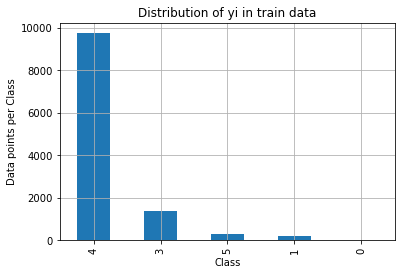

--------------------------------------------------------------------------------


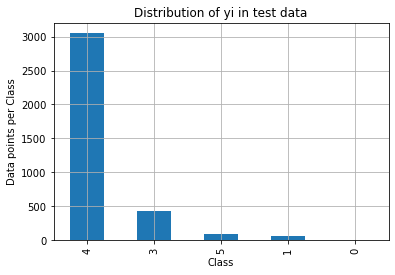

--------------------------------------------------------------------------------


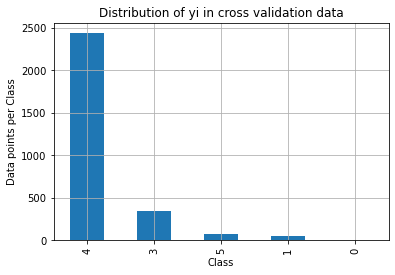

In [6]:
#plotting the distribution of dependent variable in all three sets
train_class_distribution = x_train['popularity'].value_counts()
test_class_distribution = x_test['popularity'].value_counts()
cv_class_distribution = x_cv['popularity'].value_counts()


train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


    


print('-'*80)

test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()



print('-'*80)

cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()



# Ml Models


# Logestic Regression

preprocessing the data for logestic regression

In [12]:
#one hot encoding Category_1
one=OneHotEncoder()
one.fit(train['Category_1'].values.reshape(-1,1))
Category_1_one_x_train=one.fit_transform(x_train["Category_1"].values.reshape(-1,1)).toarray()
Category_1_one_x_cv=one.fit_transform(x_cv["Category_1"].values.reshape(-1,1)).toarray()
Category_1_one_x_test=one.fit_transform(x_test["Category_1"].values.reshape(-1,1)).toarray()


#one hot encoding Category_2
one=OneHotEncoder()
one.fit(train['Category_2'].values.reshape(-1,1))
Category_2_one_x_train=one.fit_transform(x_train["Category_2"].values.reshape(-1,1)).toarray()
Category_2_one_x_cv=one.fit_transform(x_cv["Category_2"].values.reshape(-1,1)).toarray()
Category_2_one_x_test=one.fit_transform(x_test["Category_2"].values.reshape(-1,1)).toarray()




In [11]:
# StandardScaler of  Store_Ratio
stan=StandardScaler()
stan.fit(train["Store_Ratio"].values.reshape(-1,1))
Store_Ratio_stan_x_train=stan.fit_transform(x_train["Store_Ratio"].values.reshape(-1,1))
Store_Ratio_stan_x_cv=stan.fit_transform(x_cv["Store_Ratio"].values.reshape(-1,1))
Store_Ratio_stan_x_test=stan.fit_transform(x_test["Store_Ratio"].values.reshape(-1,1))

# StandardScaler of  Basket_Ratio
stan=StandardScaler()
stan.fit(train["Basket_Ratio"].values.reshape(-1,1))
Basket_Ratio_stan_x_train=stan.fit_transform(x_train["Basket_Ratio"].values.reshape(-1,1))
Basket_Ratio_stan_x_cv=stan.fit_transform(x_cv["Basket_Ratio"].values.reshape(-1,1))
Basket_Ratio_stan_x_test=stan.fit_transform(x_test["Basket_Ratio"].values.reshape(-1,1))

# StandardScaler of  Store_Score
stan=StandardScaler()
stan.fit(train["Store_Score"].values.reshape(-1,1))
Store_Score_stan_x_train=stan.fit_transform(x_train["Store_Score"].values.reshape(-1,1))
Store_Score_stan_x_cv=stan.fit_transform(x_cv["Store_Score"].values.reshape(-1,1))
Store_Score_stan_x_test=stan.fit_transform(x_test["Store_Score"].values.reshape(-1,1))


# StandardScaler of  Store_Presence
stan=StandardScaler()
stan.fit(train["Store_Presence"].values.reshape(-1,1))
Store_Presence_stan_x_train=stan.fit_transform(x_train["Store_Presence"].values.reshape(-1,1))
Store_Presence_stan_x_cv=stan.fit_transform(x_cv["Store_Presence"].values.reshape(-1,1))
Store_Presence_stan_x_test=stan.fit_transform(x_test["Store_Presence"].values.reshape(-1,1))

# StandardScaler of  Score_1
stan=StandardScaler()
stan.fit(train["Score_1"].values.reshape(-1,1))
Score_1_stan_x_train=stan.fit_transform(x_train["Score_1"].values.reshape(-1,1))
Score_1_stan_x_cv=stan.fit_transform(x_cv["Score_1"].values.reshape(-1,1))
Score_1_stan_x_test=stan.fit_transform(x_test["Score_1"].values.reshape(-1,1))

# StandardScaler of  Score_2
stan=StandardScaler()
stan.fit(train["Score_2"].values.reshape(-1,1))
Score_2_stan_x_train=stan.fit_transform(x_train["Score_2"].values.reshape(-1,1))
Score_2_stan_x_cv=stan.fit_transform(x_cv["Score_2"].values.reshape(-1,1))
Score_2_stan_x_test=stan.fit_transform(x_test["Score_2"].values.reshape(-1,1))

# StandardScaler of  Score_3
stan=StandardScaler()
stan.fit(train["Score_3"].values.reshape(-1,1))
Score_3_stan_x_train=stan.fit_transform(x_train["Score_3"].values.reshape(-1,1))
Score_3_stan_x_cv=stan.fit_transform(x_cv["Score_3"].values.reshape(-1,1))
Score_3_stan_x_test=stan.fit_transform(x_test["Score_3"].values.reshape(-1,1))

# StandardScaler of  Score_4
stan=StandardScaler()
stan.fit(train["Score_4"].values.reshape(-1,1))
Score_4_stan_x_train=stan.fit_transform(x_train["Score_4"].values.reshape(-1,1))
Score_4_stan_x_cv=stan.fit_transform(x_cv["Score_4"].values.reshape(-1,1))
Score_4_stan_x_test=stan.fit_transform(x_test["Score_4"].values.reshape(-1,1))

# StandardScaler of  time
stan=StandardScaler()
stan.fit(train["time"].values.reshape(-1,1))
time_stan_x_train=stan.fit_transform(x_train["time"].values.reshape(-1,1))
time_stan_x_cv=stan.fit_transform(x_cv["time"].values.reshape(-1,1))
time_stan_x_test=stan.fit_transform(x_test["time"].values.reshape(-1,1))

# StandardScaler of  time
stan=StandardScaler()
stan.fit(train["time"].values.reshape(-1,1))
time_stan_x_train=stan.fit_transform(x_train["time"].values.reshape(-1,1))
time_stan_x_cv=stan.fit_transform(x_cv["time"].values.reshape(-1,1))
time_stan_x_test=stan.fit_transform(x_test["time"].values.reshape(-1,1))


In [13]:
#combining all the columns
t=np.hstack((Store_Ratio_stan_x_train,Basket_Ratio_stan_x_train,Category_1_one_x_train,Store_Score_stan_x_train,Category_2_one_x_train,Store_Presence_stan_x_train,Score_1_stan_x_train,Score_2_stan_x_train,Score_3_stan_x_train,Score_4_stan_x_train,time_stan_x_train))
cv=np.hstack((Store_Ratio_stan_x_cv,Basket_Ratio_stan_x_cv,Category_1_one_x_cv,Store_Score_stan_x_cv,Category_2_one_x_cv,Store_Presence_stan_x_cv,Score_1_stan_x_cv,Score_2_stan_x_cv,Score_3_stan_x_cv,Score_4_stan_x_cv,time_stan_x_cv))
test=np.hstack((Store_Ratio_stan_x_test,Basket_Ratio_stan_x_test,Category_1_one_x_test,Store_Score_stan_x_test,Category_2_one_x_test,Store_Presence_stan_x_test,Score_1_stan_x_test,Score_2_stan_x_test,Score_3_stan_x_test,Score_4_stan_x_test,time_stan_x_test))

print("shape of train",t.shape)
print("shape of cv",cv.shape)
print("shape of test",test.shape)



shape of train (11652, 23)
shape of cv (2914, 23)
shape of test (3642, 23)


In [26]:
#linear Regression
def objective(trial):
      alpha = trial.suggest_categorical('alpha', [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
      penalty = trial.suggest_categorical('penalty', ["l2","l1",'elasticnet'])
      clf =SGDClassifier(alpha=alpha,random_state=1,penalty=penalty,loss='log',class_weight='balanced')
      clf.fit(t,y_train)
      sig_clf=CalibratedClassifierCV(clf)
      sig_clf.fit(t,y_train)
      pred=sig_clf.predict_proba(cv)
      return metrics.log_loss(y_cv,pred)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

[I 2021-03-14 10:50:09,970] A new study created in memory with name: no-name-cd394bcc-609f-4c98-8bea-fc8ce36c11b2
[I 2021-03-14 10:50:12,036] Trial 0 finished with value: 0.47911728584091745 and parameters: {'alpha': 0.01, 'penalty': 'elasticnet'}. Best is trial 0 with value: 0.47911728584091745.
[I 2021-03-14 10:50:15,175] Trial 1 finished with value: 0.5749547700351715 and parameters: {'alpha': 10, 'penalty': 'elasticnet'}. Best is trial 0 with value: 0.47911728584091745.
[I 2021-03-14 10:50:17,421] Trial 2 finished with value: 0.4815622302983013 and parameters: {'alpha': 0.001, 'penalty': 'l2'}. Best is trial 0 with value: 0.47911728584091745.
[I 2021-03-14 10:50:21,822] Trial 3 finished with value: 0.4883263756941596 and parameters: {'alpha': 0.0001, 'penalty': 'l2'}. Best is trial 0 with value: 0.47911728584091745.
[I 2021-03-14 10:50:24,251] Trial 4 finished with value: 0.4958167500443088 and parameters: {'alpha': 10, 'penalty': 'l2'}. Best is trial 0 with value: 0.47911728584091

In [27]:
#predicting with best hyperparameters
clf =SGDClassifier(alpha=0.01,random_state=1,penalty='l1',loss='log',class_weight='balanced')
clf.fit(t,y_train)
sig_clf=CalibratedClassifierCV(clf)
sig_clf.fit(t,y_train)
pred=sig_clf.predict_proba(cv)
print('the log loss of cv is',metrics.log_loss(y_cv,pred))
pred=sig_clf.predict_proba(test)
print('the log loss of test is',metrics.log_loss(y_test,pred))

the log loss of cv is 0.47862250376209053
the log loss of test is 0.48374084967166253


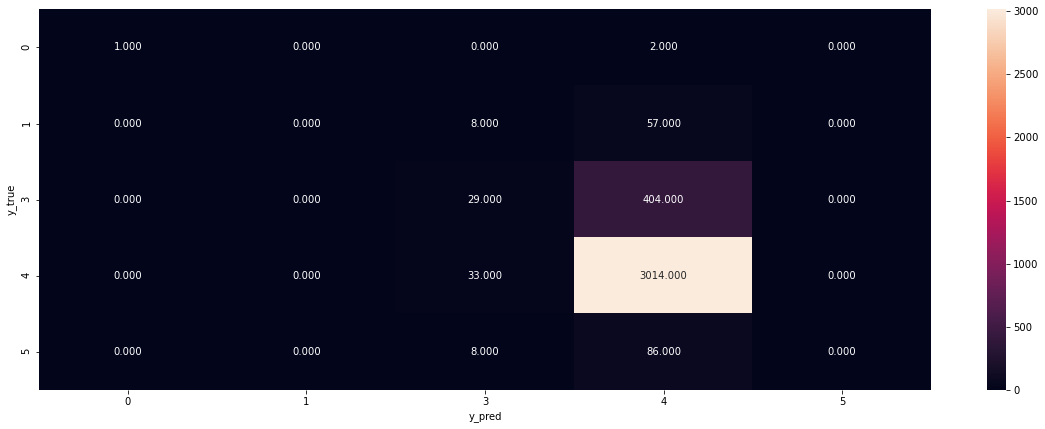

******************************
Precision matrix


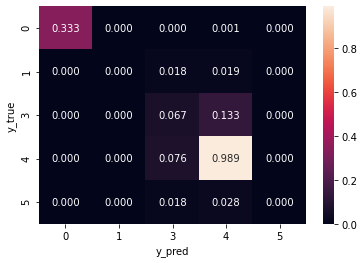

******************************
Recall matrix


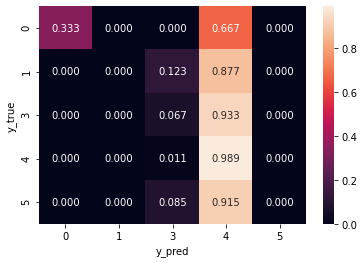

In [23]:
#plot the confusion on test data
pred=sig_clf.predict(test)
confusion_plot(y_test,pred)

# SVC

In [ ]:
#one hot encoding Category_1
one=OneHotEncoder()
one.fit(train['Category_1'].values.reshape(-1,1))
Category_1_one_x_train=one.fit_transform(x_train["Category_1"].values.reshape(-1,1)).toarray()
Category_1_one_x_cv=one.fit_transform(x_cv["Category_1"].values.reshape(-1,1)).toarray()
Category_1_one_x_test=one.fit_transform(x_test["Category_1"].values.reshape(-1,1)).toarray()


#one hot encoding Category_2
one=OneHotEncoder()
one.fit(train['Category_2'].values.reshape(-1,1))
Category_2_one_x_train=one.fit_transform(x_train["Category_2"].values.reshape(-1,1)).toarray()
Category_2_one_x_cv=one.fit_transform(x_cv["Category_2"].values.reshape(-1,1)).toarray()
Category_2_one_x_test=one.fit_transform(x_test["Category_2"].values.reshape(-1,1)).toarray()




In [28]:
# MinMax of  Store_Ratio
stan=MinMaxScaler()
stan.fit(train["Store_Ratio"].values.reshape(-1,1))
Store_Ratio_stan_x_train=stan.fit_transform(x_train["Store_Ratio"].values.reshape(-1,1))
Store_Ratio_stan_x_cv=stan.fit_transform(x_cv["Store_Ratio"].values.reshape(-1,1))
Store_Ratio_stan_x_test=stan.fit_transform(x_test["Store_Ratio"].values.reshape(-1,1))

# MinMax of  Basket_Ratio
stan=MinMaxScaler()
stan.fit(train["Basket_Ratio"].values.reshape(-1,1))
Basket_Ratio_stan_x_train=stan.fit_transform(x_train["Basket_Ratio"].values.reshape(-1,1))
Basket_Ratio_stan_x_cv=stan.fit_transform(x_cv["Basket_Ratio"].values.reshape(-1,1))
Basket_Ratio_stan_x_test=stan.fit_transform(x_test["Basket_Ratio"].values.reshape(-1,1))

# MinMax of  Store_Score
stan=MinMaxScaler()
stan.fit(train["Store_Score"].values.reshape(-1,1))
Store_Score_stan_x_train=stan.fit_transform(x_train["Store_Score"].values.reshape(-1,1))
Store_Score_stan_x_cv=stan.fit_transform(x_cv["Store_Score"].values.reshape(-1,1))
Store_Score_stan_x_test=stan.fit_transform(x_test["Store_Score"].values.reshape(-1,1))


# MinMax of  Store_Presence
stan=MinMaxScaler()
stan.fit(train["Store_Presence"].values.reshape(-1,1))
Store_Presence_stan_x_train=stan.fit_transform(x_train["Store_Presence"].values.reshape(-1,1))
Store_Presence_stan_x_cv=stan.fit_transform(x_cv["Store_Presence"].values.reshape(-1,1))
Store_Presence_stan_x_test=stan.fit_transform(x_test["Store_Presence"].values.reshape(-1,1))

# MinMax of  Score_1
stan=MinMaxScaler()
stan.fit(train["Score_1"].values.reshape(-1,1))
Score_1_stan_x_train=stan.fit_transform(x_train["Score_1"].values.reshape(-1,1))
Score_1_stan_x_cv=stan.fit_transform(x_cv["Score_1"].values.reshape(-1,1))
Score_1_stan_x_test=stan.fit_transform(x_test["Score_1"].values.reshape(-1,1))

# MinMax of  Score_2
stan=MinMaxScaler()
stan.fit(train["Score_2"].values.reshape(-1,1))
Score_2_stan_x_train=stan.fit_transform(x_train["Score_2"].values.reshape(-1,1))
Score_2_stan_x_cv=stan.fit_transform(x_cv["Score_2"].values.reshape(-1,1))
Score_2_stan_x_test=stan.fit_transform(x_test["Score_2"].values.reshape(-1,1))

# MinMax of  Score_3
stan=MinMaxScaler()
stan.fit(train["Score_3"].values.reshape(-1,1))
Score_3_stan_x_train=stan.fit_transform(x_train["Score_3"].values.reshape(-1,1))
Score_3_stan_x_cv=stan.fit_transform(x_cv["Score_3"].values.reshape(-1,1))
Score_3_stan_x_test=stan.fit_transform(x_test["Score_3"].values.reshape(-1,1))

# MinMax of  Score_4
stan=MinMaxScaler()
stan.fit(train["Score_4"].values.reshape(-1,1))
Score_4_stan_x_train=stan.fit_transform(x_train["Score_4"].values.reshape(-1,1))
Score_4_stan_x_cv=stan.fit_transform(x_cv["Score_4"].values.reshape(-1,1))
Score_4_stan_x_test=stan.fit_transform(x_test["Score_4"].values.reshape(-1,1))

# MinMax of  time
stan=MinMaxScaler()
stan.fit(train["time"].values.reshape(-1,1))
time_stan_x_train=stan.fit_transform(x_train["time"].values.reshape(-1,1))
time_stan_x_cv=stan.fit_transform(x_cv["time"].values.reshape(-1,1))
time_stan_x_test=stan.fit_transform(x_test["time"].values.reshape(-1,1))

# MinMax of  time
stan=MinMaxScaler()
stan.fit(train["time"].values.reshape(-1,1))
time_stan_x_train=stan.fit_transform(x_train["time"].values.reshape(-1,1))
time_stan_x_cv=stan.fit_transform(x_cv["time"].values.reshape(-1,1))
time_stan_x_test=stan.fit_transform(x_test["time"].values.reshape(-1,1))


In [29]:
#combining all the columns
t=np.hstack((Store_Ratio_stan_x_train,Basket_Ratio_stan_x_train,Category_1_one_x_train,Store_Score_stan_x_train,Category_2_one_x_train,Store_Presence_stan_x_train,Score_1_stan_x_train,Score_2_stan_x_train,Score_3_stan_x_train,Score_4_stan_x_train,time_stan_x_train))
cv=np.hstack((Store_Ratio_stan_x_cv,Basket_Ratio_stan_x_cv,Category_1_one_x_cv,Store_Score_stan_x_cv,Category_2_one_x_cv,Store_Presence_stan_x_cv,Score_1_stan_x_cv,Score_2_stan_x_cv,Score_3_stan_x_cv,Score_4_stan_x_cv,time_stan_x_cv))
test=np.hstack((Store_Ratio_stan_x_test,Basket_Ratio_stan_x_test,Category_1_one_x_test,Store_Score_stan_x_test,Category_2_one_x_test,Store_Presence_stan_x_test,Score_1_stan_x_test,Score_2_stan_x_test,Score_3_stan_x_test,Score_4_stan_x_test,time_stan_x_test))

print("shape of train",t.shape)
print("shape of cv",cv.shape)
print("shape of test",test.shape)



shape of train (11652, 23)
shape of cv (2914, 23)
shape of test (3642, 23)


In [36]:
#linear SVC
def objective(trial):
      C = trial.suggest_categorical('C', [0.1, 1, 10, 100, 1000])
      gamma = trial.suggest_categorical('gamma', [1, 0.1, 0.01, 0.001, 0.0001])
      clf =SVC(C=C,gamma=gamma,class_weight='balanced',random_state=1)
      clf.fit(t,y_train)
      sig_clf=CalibratedClassifierCV(clf)
      sig_clf.fit(t,y_train)
      pred=sig_clf.predict_proba(cv)
      return metrics.log_loss(y_cv,pred)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

[I 2021-03-14 11:08:52,603] A new study created in memory with name: no-name-91f990e9-c347-46ae-aa81-80be7fd721ae
[I 2021-03-14 11:10:16,994] Trial 0 finished with value: 0.5212689904787915 and parameters: {'C': 10, 'gamma': 0.1}. Best is trial 0 with value: 0.5212689904787915.
[I 2021-03-14 11:12:36,049] Trial 1 finished with value: 0.5319822144681173 and parameters: {'C': 10, 'gamma': 0.01}. Best is trial 0 with value: 0.5212689904787915.
[I 2021-03-14 11:14:47,725] Trial 2 finished with value: 0.5258485517196149 and parameters: {'C': 10, 'gamma': 0.0001}. Best is trial 0 with value: 0.5212689904787915.
[I 2021-03-14 11:16:31,096] Trial 3 finished with value: 0.5355471645442258 and parameters: {'C': 10, 'gamma': 0.001}. Best is trial 0 with value: 0.5212689904787915.
[I 2021-03-14 11:18:06,155] Trial 4 finished with value: 0.5226157480919348 and parameters: {'C': 1000, 'gamma': 0.01}. Best is trial 0 with value: 0.5212689904787915.
[I 2021-03-14 11:20:59,920] Trial 5 finished with va

In [37]:
#predicting with best hyperparameters
clf =SVC(C=100,gamma=0.1,class_weight='balanced',random_state=1)
clf.fit(t,y_train)
sig_clf=CalibratedClassifierCV(clf)
sig_clf.fit(t,y_train)
pred=sig_clf.predict_proba(cv)
print('the log loss of cv is',metrics.log_loss(y_cv,pred))
pred=sig_clf.predict_proba(test)
print('the log loss of test is',metrics.log_loss(y_test,pred))

the log loss of cv is 0.5206209633890707
the log loss of test is 0.5224509011865924


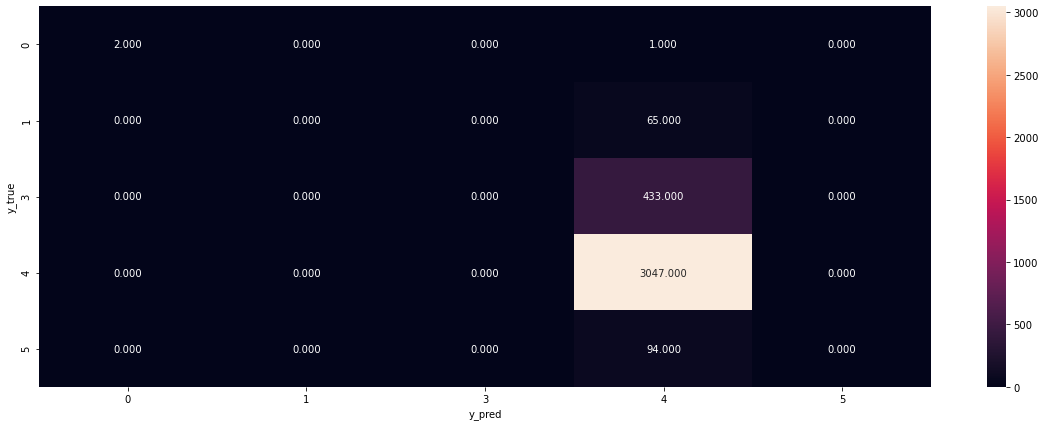

******************************
Precision matrix


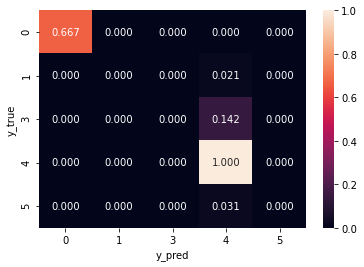

******************************
Recall matrix


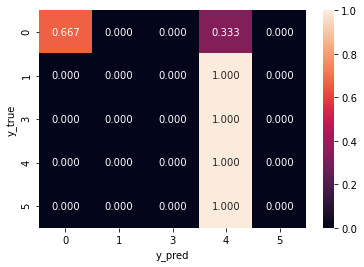

In [38]:
#plot the confusion on test data
pred=sig_clf.predict(test)
confusion_plot(y_test,pred)

In [22]:
#Naive Bayes
stan=MinMaxScaler()
stan.fit(train["Store_Score"].values.reshape(-1,1))
time_stan_x_train=stan.fit_transform(x_train["Store_Score"].values.reshape(-1,1))
time_stan_x_cv=stan.fit_transform(x_cv["Store_Score"].values.reshape(-1,1))
time_stan_x_test=stan.fit_transform(x_test["Store_Score"].values.reshape(-1,1))

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time,popularity
8341,0.353,0.0717,5,-21.734,1,0.96700,0.566000,0.1160,0.2040,107.590,280750,4
15258,0.641,0.7320,5,-7.570,1,0.01390,0.000003,0.0620,0.7630,92.057,262107,4
14141,0.155,0.9750,0,-18.344,0,0.67900,0.948000,0.5250,0.0144,141.025,300360,5
7364,0.581,0.7600,0,-3.962,1,0.16000,0.000000,0.1830,0.5230,104.099,205787,4
7941,0.592,0.4210,2,-12.054,0,0.01570,0.001210,0.1870,0.2860,115.986,289986,4
8660,0.703,0.5940,5,-6.146,0,0.34200,0.000000,0.1230,0.4750,153.848,114893,4
13144,0.609,0.4450,7,-9.129,1,0.60300,0.000007,0.1040,0.1660,118.393,228707,3
4137,0.502,0.0152,8,-25.128,1,0.99500,0.948000,0.0826,0.4150,76.811,143000,3
17444,0.586,0.5220,1,-9.798,0,0.87000,0.893000,0.1100,0.3510,73.994,167027,4
4276,0.368,0.9500,3,-2.551,1,0.00292,0.001130,0.1460,0.7330,141.124,206753,4


In [12]:
nbtrain=np.hstack((x_train.drop(["popularity","Store_Score"],axis=1),time_stan_x_train))  
nbcv=np.hstack((x_cv.drop(["popularity","Store_Score"],axis=1),time_stan_x_cv))
nbtest=np.hstack((x_test.drop(["popularity","Store_Score"],axis=1),time_stan_x_test))
    

In [25]:
#ComplementNB                                         
cv_error=[]

alpha = [0.00001, 0.0001, 0.001, 0.1, 1,2,3,10, 100,1000]
for i in alpha:
    print("for alpha",i)
    clf=ComplementNB(alpha=i)
    clf.fit(nbtrain,y_train)
    sig_clf=CalibratedClassifierCV(clf)
    sig_clf.fit(nbtrain,y_train)
    pred=sig_clf.predict_proba(nbcv)
    loss=metrics.log_loss(y_cv,pred)
    print("the loss is",loss )
    cv_error.append(loss)                                               
    

for alpha 1e-05
the loss is 0.5296715970800939
for alpha 0.0001
the loss is 0.5296715968068694
for alpha 0.001
the loss is 0.5296715940724175
for alpha 0.1
the loss is 0.529671293293892
for alpha 1
the loss is 0.5296685582996309
for alpha 2
the loss is 0.5296655170846901
for alpha 3
the loss is 0.5296624717928591
for alpha 10
the loss is 0.5296409562184983
for alpha 100
the loss is 0.5304431900263393
for alpha 1000
the loss is 0.567117582524048


In [65]:
clf=ComplementNB(alpha=alpha[np.argmax(cv_error)])
clf.fit(nbtrain,y_train)
sig_clf=CalibratedClassifierCV(clf)
sig_clf.fit(nbtrain,y_train)
pred=sig_clf.predict_proba(nbcv)
print("log loss",metrics.log_loss(y_cv,pred))
pred=sig_clf.predict_proba(nbtest)
print("log loss",metrics.log_loss(y_test,pred))

log loss 0.5296715970800939
log loss 0.5291662276943933


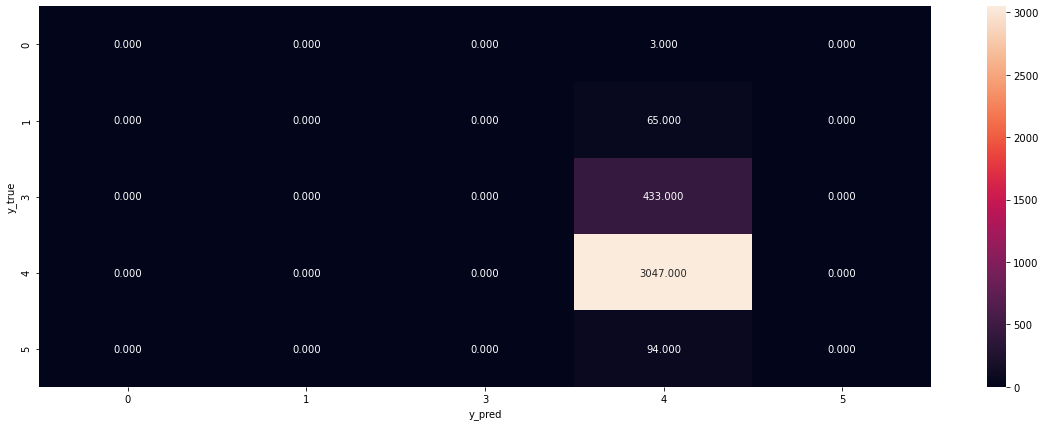

******************************
Precision matrix


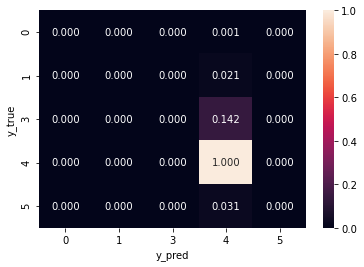

******************************
Recall matrix


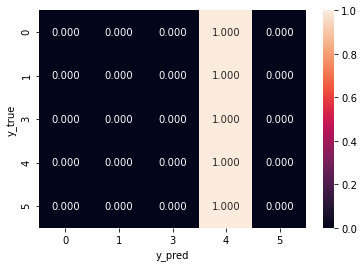

In [66]:
#plot the confusion on test data
pred=sig_clf.predict(nbtest)
confusion_plot(y_test,pred)

# KNN

In [29]:
#one hot encoding Category_1
one=OneHotEncoder()
one.fit(train['Category_1'].values.reshape(-1,1))
Category_1_one_x_train=one.fit_transform(x_train["Category_1"].values.reshape(-1,1)).toarray()
Category_1_one_x_cv=one.fit_transform(x_cv["Category_1"].values.reshape(-1,1)).toarray()
Category_1_one_x_test=one.fit_transform(x_test["Category_1"].values.reshape(-1,1)).toarray()


#one hot encoding Category_2
one=OneHotEncoder()
one.fit(train['Category_2'].values.reshape(-1,1))
Category_2_one_x_train=one.fit_transform(x_train["Category_2"].values.reshape(-1,1)).toarray()
Category_2_one_x_cv=one.fit_transform(x_cv["Category_2"].values.reshape(-1,1)).toarray()
Category_2_one_x_test=one.fit_transform(x_test["Category_2"].values.reshape(-1,1)).toarray()




In [30]:
# MinMax of  Store_Ratio
stan=MinMaxScaler()
stan.fit(train["Store_Ratio"].values.reshape(-1,1))
Store_Ratio_stan_x_train=stan.fit_transform(x_train["Store_Ratio"].values.reshape(-1,1))
Store_Ratio_stan_x_cv=stan.fit_transform(x_cv["Store_Ratio"].values.reshape(-1,1))
Store_Ratio_stan_x_test=stan.fit_transform(x_test["Store_Ratio"].values.reshape(-1,1))

# MinMax of  Basket_Ratio
stan=MinMaxScaler()
stan.fit(train["Basket_Ratio"].values.reshape(-1,1))
Basket_Ratio_stan_x_train=stan.fit_transform(x_train["Basket_Ratio"].values.reshape(-1,1))
Basket_Ratio_stan_x_cv=stan.fit_transform(x_cv["Basket_Ratio"].values.reshape(-1,1))
Basket_Ratio_stan_x_test=stan.fit_transform(x_test["Basket_Ratio"].values.reshape(-1,1))

# MinMax of  Store_Score
stan=MinMaxScaler()
stan.fit(train["Store_Score"].values.reshape(-1,1))
Store_Score_stan_x_train=stan.fit_transform(x_train["Store_Score"].values.reshape(-1,1))
Store_Score_stan_x_cv=stan.fit_transform(x_cv["Store_Score"].values.reshape(-1,1))
Store_Score_stan_x_test=stan.fit_transform(x_test["Store_Score"].values.reshape(-1,1))


# MinMax of  Store_Presence
stan=MinMaxScaler()
stan.fit(train["Store_Presence"].values.reshape(-1,1))
Store_Presence_stan_x_train=stan.fit_transform(x_train["Store_Presence"].values.reshape(-1,1))
Store_Presence_stan_x_cv=stan.fit_transform(x_cv["Store_Presence"].values.reshape(-1,1))
Store_Presence_stan_x_test=stan.fit_transform(x_test["Store_Presence"].values.reshape(-1,1))

# MinMax of  Score_1
stan=MinMaxScaler()
stan.fit(train["Score_1"].values.reshape(-1,1))
Score_1_stan_x_train=stan.fit_transform(x_train["Score_1"].values.reshape(-1,1))
Score_1_stan_x_cv=stan.fit_transform(x_cv["Score_1"].values.reshape(-1,1))
Score_1_stan_x_test=stan.fit_transform(x_test["Score_1"].values.reshape(-1,1))

# MinMax of  Score_2
stan=MinMaxScaler()
stan.fit(train["Score_2"].values.reshape(-1,1))
Score_2_stan_x_train=stan.fit_transform(x_train["Score_2"].values.reshape(-1,1))
Score_2_stan_x_cv=stan.fit_transform(x_cv["Score_2"].values.reshape(-1,1))
Score_2_stan_x_test=stan.fit_transform(x_test["Score_2"].values.reshape(-1,1))

# MinMax of  Score_3
stan=MinMaxScaler()
stan.fit(train["Score_3"].values.reshape(-1,1))
Score_3_stan_x_train=stan.fit_transform(x_train["Score_3"].values.reshape(-1,1))
Score_3_stan_x_cv=stan.fit_transform(x_cv["Score_3"].values.reshape(-1,1))
Score_3_stan_x_test=stan.fit_transform(x_test["Score_3"].values.reshape(-1,1))

# MinMax of  Score_4
stan=MinMaxScaler()
stan.fit(train["Score_4"].values.reshape(-1,1))
Score_4_stan_x_train=stan.fit_transform(x_train["Score_4"].values.reshape(-1,1))
Score_4_stan_x_cv=stan.fit_transform(x_cv["Score_4"].values.reshape(-1,1))
Score_4_stan_x_test=stan.fit_transform(x_test["Score_4"].values.reshape(-1,1))

# MinMax of  time
stan=MinMaxScaler()
stan.fit(train["time"].values.reshape(-1,1))
time_stan_x_train=stan.fit_transform(x_train["time"].values.reshape(-1,1))
time_stan_x_cv=stan.fit_transform(x_cv["time"].values.reshape(-1,1))
time_stan_x_test=stan.fit_transform(x_test["time"].values.reshape(-1,1))

# MinMax of  time
stan=MinMaxScaler()
stan.fit(train["time"].values.reshape(-1,1))
time_stan_x_train=stan.fit_transform(x_train["time"].values.reshape(-1,1))
time_stan_x_cv=stan.fit_transform(x_cv["time"].values.reshape(-1,1))
time_stan_x_test=stan.fit_transform(x_test["time"].values.reshape(-1,1))


In [35]:
#combining all the columns
t=np.hstack((Store_Ratio_stan_x_train,Basket_Ratio_stan_x_train,Category_1_one_x_train,Store_Score_stan_x_train,Category_2_one_x_train,Store_Presence_stan_x_train,Score_1_stan_x_train,Score_2_stan_x_train,Score_3_stan_x_train,Score_4_stan_x_train,time_stan_x_train))
cv=np.hstack((Store_Ratio_stan_x_cv,Basket_Ratio_stan_x_cv,Category_1_one_x_cv,Store_Score_stan_x_cv,Category_2_one_x_cv,Store_Presence_stan_x_cv,Score_1_stan_x_cv,Score_2_stan_x_cv,Score_3_stan_x_cv,Score_4_stan_x_cv,time_stan_x_cv))
test=np.hstack((Store_Ratio_stan_x_test,Basket_Ratio_stan_x_test,Category_1_one_x_test,Store_Score_stan_x_test,Category_2_one_x_test,Store_Presence_stan_x_test,Score_1_stan_x_test,Score_2_stan_x_test,Score_3_stan_x_test,Score_4_stan_x_test,time_stan_x_test))

print("shape of train",t.shape)
print("shape of cv",cv.shape)
print("shape of test",test.shape)



shape of train (11652, 23)
shape of cv (2914, 23)
shape of test (3642, 23)


In [70]:
#KNN                                         
cv_error=[]
n_neighbors = [34,35,36,37,38,39]
for i in n_neighbors:
    print("for n_neighbors",i)
    clf=KNeighborsClassifier(n_neighbors=i,weights='distance',metric='euclidean',n_jobs=-1)
    clf.fit(t,y_train)
    sig_clf=CalibratedClassifierCV(clf)
    sig_clf.fit(t,y_train)
    pred=sig_clf.predict_proba(cv)
    loss=metrics.log_loss(y_cv,pred)
    print("the loss is",loss )
    cv_error.append(loss)                                               
    

for n_neighbors 34
the loss is 0.4693101685274165
for n_neighbors 35
the loss is 0.4693122104904654
for n_neighbors 36
the loss is 0.46940073406517246
for n_neighbors 37
the loss is 0.4695639305588115
for n_neighbors 38
the loss is 0.469586273203915
for n_neighbors 39
the loss is 0.46960846901056236


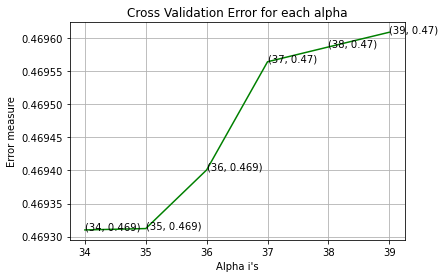

In [71]:

fig, ax = plt.subplots()
ax.plot(n_neighbors, cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((n_neighbors[i],np.round(txt,3)), (n_neighbors[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [79]:
#predicting with best hyperparameters
clf =KNeighborsClassifier(n_neighbors=34,weights='distance',metric='euclidean',n_jobs=-1)
clf.fit(t,y_train)
sig_clf=CalibratedClassifierCV(clf)
sig_clf.fit(t,y_train)
pred=sig_clf.predict_proba(cv)
print('the log loss of cv is',metrics.log_loss(y_cv,pred))
pred=sig_clf.predict_proba(test)
print('the log loss of test is',metrics.log_loss(y_test,pred))

the log loss of cv is 0.4693101685274165
the log loss of test is 0.47969264026019687


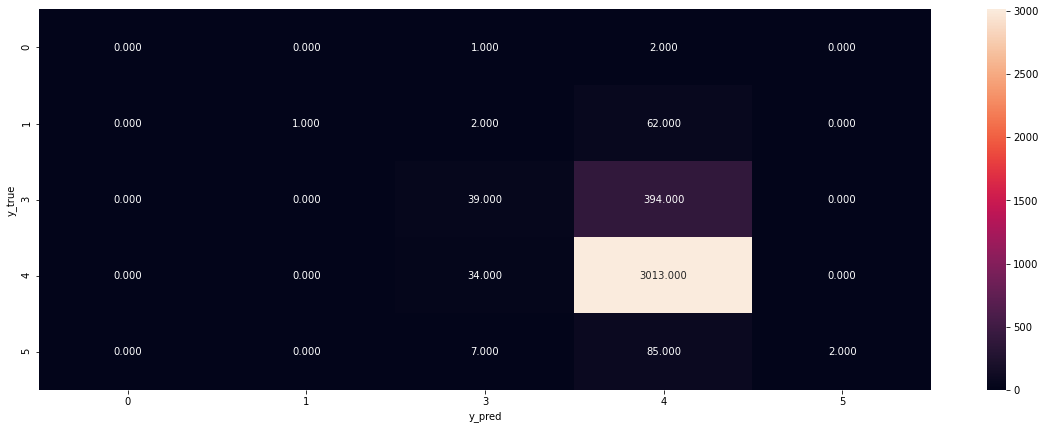

******************************
Precision matrix


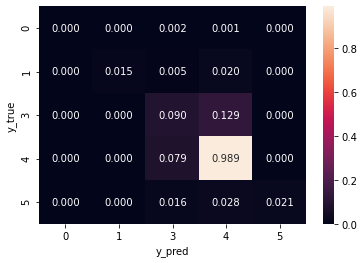

******************************
Recall matrix


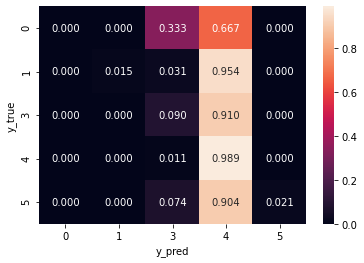

In [80]:
#plot the confusion on test data
pred=sig_clf.predict(test)
confusion_plot(y_test,pred)

# Decision Tree

In [95]:
# Decision Trees
max_depth=[26,28,30,32,34]
cv_error=[]
for i in max_depth:
    print("for max_depth",i)
    clf=DecisionTreeClassifier(max_depth=i,random_state=1,class_weight='balanced')
    clf.fit(x_train.drop(["popularity"],axis=1),y_train)
    sig_clf=CalibratedClassifierCV(clf)
    sig_clf.fit(x_train.drop(["popularity"],axis=1),y_train)
    pred=sig_clf.predict_proba(x_cv.drop(["popularity"],axis=1))
    loss=metrics.log_loss(y_cv,pred)
    print("the loss is",loss )
    cv_error.append(loss) 
    

for max_depth 26
the loss is 0.4820701329123526
for max_depth 28
the loss is 0.47950215392665885
for max_depth 30
the loss is 0.4775457127039265
for max_depth 32
the loss is 0.47901193633647904
for max_depth 34
the loss is 0.47901193633647904


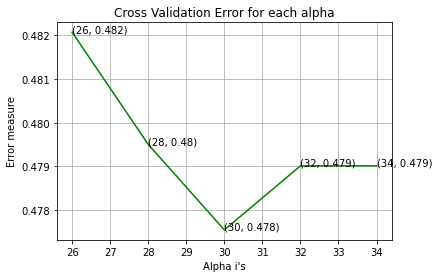

In [96]:

fig, ax = plt.subplots()
ax.plot(max_depth, cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((max_depth[i],np.round(txt,3)), (max_depth[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [98]:
clf=DecisionTreeClassifier(max_depth=30,random_state=1,class_weight='balanced')
clf.fit(x_train.drop(["popularity"],axis=1),y_train)
sig_clf=CalibratedClassifierCV(clf)
sig_clf.fit(x_train.drop(["popularity"],axis=1),y_train)
pred=sig_clf.predict_proba(x_cv.drop(["popularity"],axis=1))
print("loss of cv",metrics.log_loss(y_cv,pred))
pred=sig_clf.predict_proba(x_test.drop(["popularity"],axis=1))
print("loss of test",metrics.log_loss(y_test,pred))

loss of cv 0.4775457127039265
loss of test 0.4764339601530611


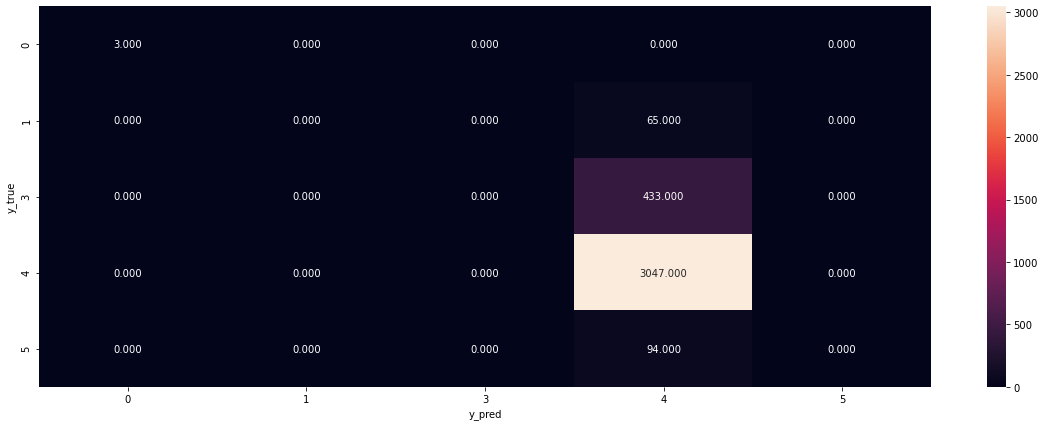

******************************
Precision matrix


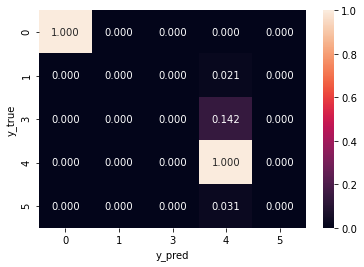

******************************
Recall matrix


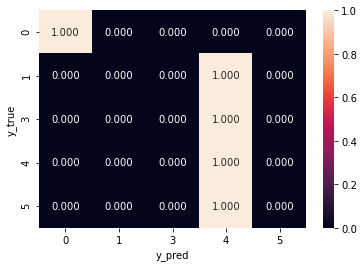

In [99]:
#plot the confusion on test data
pred=sig_clf.predict(x_test.drop(["popularity"],axis=1))
confusion_plot(y_test,pred)

# Random forest

In [12]:
#Random_forest
def objective(trial):
      n_estimators = trial.suggest_categorical('n_estimators', [400,500,600])
      max_depth = trial.suggest_categorical('max_depth', [33,34,35,36,37])
      clf =RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,class_weight='balanced',random_state=1,n_jobs=-1)
      clf.fit(x_train.drop(["popularity"],axis=1),y_train)
      sig_clf=CalibratedClassifierCV(clf)
      sig_clf.fit(x_train.drop(["popularity"],axis=1),y_train)
      pred=sig_clf.predict_proba(x_cv.drop(["popularity"],axis=1))
      return metrics.log_loss(y_cv,pred)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

[I 2021-03-16 12:06:15,658] A new study created in memory with name: no-name-d1125825-40a5-4362-9d43-e2835b4abd50
[I 2021-03-16 12:07:04,546] Trial 0 finished with value: 0.3949733367522015 and parameters: {'n_estimators': 600, 'max_depth': 37}. Best is trial 0 with value: 0.3949733367522015.
[I 2021-03-16 12:07:33,614] Trial 1 finished with value: 0.3956192773500914 and parameters: {'n_estimators': 400, 'max_depth': 33}. Best is trial 0 with value: 0.3949733367522015.
[I 2021-03-16 12:08:21,491] Trial 2 finished with value: 0.3949722321793791 and parameters: {'n_estimators': 600, 'max_depth': 33}. Best is trial 2 with value: 0.3949722321793791.
[I 2021-03-16 12:09:05,778] Trial 3 finished with value: 0.3948802653180224 and parameters: {'n_estimators': 500, 'max_depth': 36}. Best is trial 3 with value: 0.3948802653180224.
[I 2021-03-16 12:09:46,014] Trial 4 finished with value: 0.3948802653180224 and parameters: {'n_estimators': 500, 'max_depth': 36}. Best is trial 3 with value: 0.3948

In [13]:
clf=RandomForestClassifier(n_estimators=500,max_depth=35,class_weight='balanced',random_state=1,n_jobs=-1)
clf.fit(x_train.drop(["popularity"],axis=1),y_train)
sig_clf=CalibratedClassifierCV(clf)
sig_clf.fit(x_train.drop(["popularity"],axis=1),y_train)
pred=sig_clf.predict_proba(x_cv.drop(["popularity"],axis=1))
print("loss of cv",metrics.log_loss(y_cv,pred))
pred=sig_clf.predict_proba(x_test.drop(["popularity"],axis=1))
print("loss of test",metrics.log_loss(y_test,pred))

loss of cv 0.3948790600214616
loss of test 0.38661494578081534


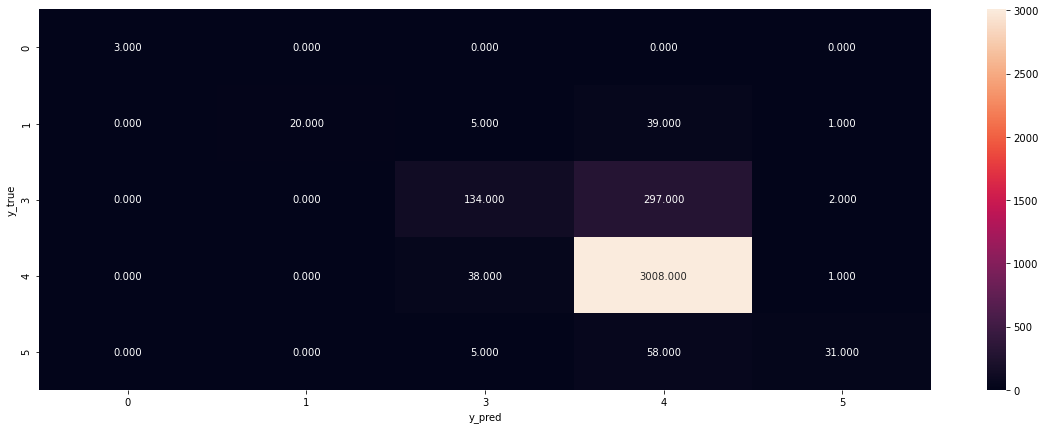

******************************
Precision matrix


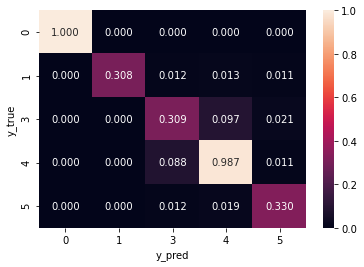

******************************
Recall matrix


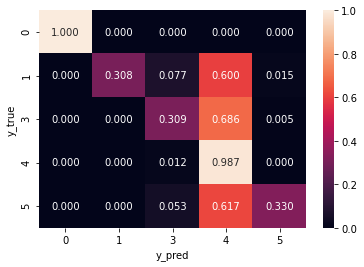

In [14]:
#plot the confusion on test data
pred=sig_clf.predict(x_test.drop(["popularity"],axis=1))
confusion_plot(y_test,pred)

# XGboost 

In [20]:
alpha=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
for i in alpha:
    clf=xgb.XGBClassifier(random_state=1,learning_rate=i)
    clf.fit(x_train.drop(["popularity"],axis=1),y_train)
    sig_clf=CalibratedClassifierCV(clf)
    sig_clf.fit(x_train.drop(["popularity"],axis=1),y_train)
    pred=sig_clf.predict_proba(x_cv.drop(["popularity"],axis=1))
    print(f"loss of cv for alpha {i} is {metrics.log_loss(y_cv,pred)}")

loss of cv for alpha 1e-05 is 0.5063146818725232
loss of cv for alpha 0.0001 is 0.48381254019438996
loss of cv for alpha 0.001 is 0.4830977194520863
loss of cv for alpha 0.01 is 0.47068790097689744
loss of cv for alpha 0.1 is 0.44595003878680645
loss of cv for alpha 1 is 0.44525457165408255
loss of cv for alpha 10 is 0.5613172717530407
loss of cv for alpha 100 is 0.5729866606909749


In [21]:
clf=xgb.XGBClassifier(random_state=1,learning_rate=1)
clf.fit(x_train.drop(["popularity"],axis=1),y_train)
sig_clf=CalibratedClassifierCV(clf)
sig_clf.fit(x_train.drop(["popularity"],axis=1),y_train)
pred=sig_clf.predict_proba(x_cv.drop(["popularity"],axis=1))
print(f"loss of cv  is {metrics.log_loss(y_cv,pred)}")
pred=sig_clf.predict_proba(x_test.drop(["popularity"],axis=1))
print("loss of test",metrics.log_loss(y_test,pred))

loss of cv  is 0.44525457165408255
loss of test 0.4302577847668829


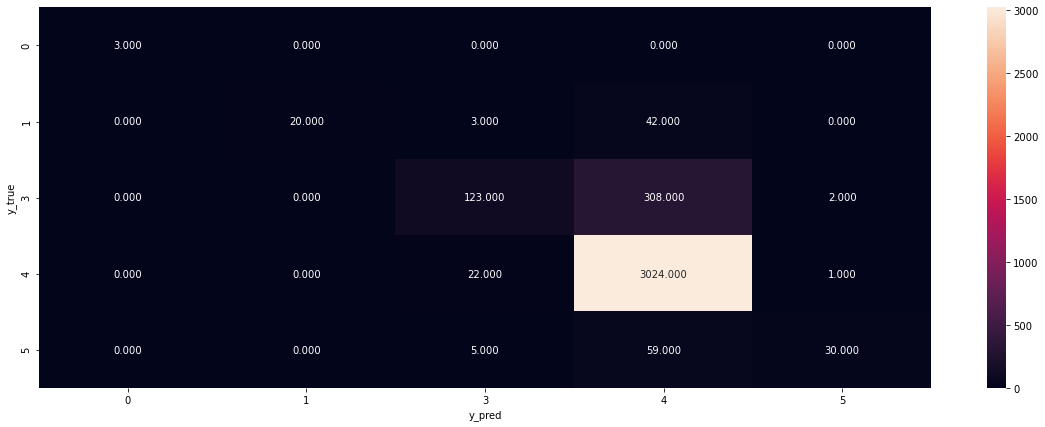

******************************
Precision matrix


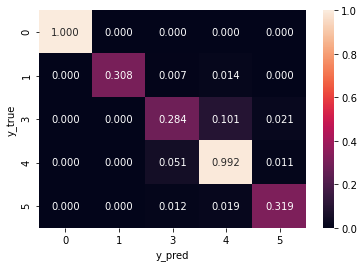

******************************
Recall matrix


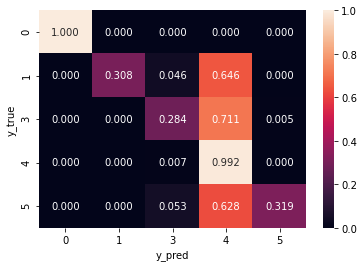

In [22]:
#plot the confusion on test data
pred=sig_clf.predict(x_test.drop(["popularity"],axis=1))
confusion_plot(y_test,pred)

Observations

From all  models we can say that random_forest is the best model in point of the accuracy 

Lets try adding some new features to data andcheck whether accuracy will increase or not


In [4]:
train.head(10)

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time,popularity
0,0.407,0.00380,2,-35.865,1,0.9920,0.94400,0.0988,0.1100,113.911,189125,4
1,0.234,0.10500,0,-19.884,1,0.9440,0.90000,0.1290,0.0382,76.332,186513,4
2,0.668,0.72600,9,-7.512,1,0.0387,0.00000,0.1340,0.4530,124.075,172143,4
3,0.184,0.00561,4,-34.357,1,0.8490,0.93100,0.1110,0.0641,79.037,184000,5
4,0.231,0.13100,6,-22.842,1,0.9370,0.00000,0.1090,0.0677,109.560,186507,3
5,0.756,0.60900,3,-7.927,1,0.2170,0.00474,0.0960,0.5370,117.023,155720,4
6,0.398,0.03360,10,-30.369,1,0.9960,0.96200,0.1300,0.6120,72.166,134500,4
7,0.717,0.69900,5,-5.665,0,0.2230,0.00000,0.1390,0.6890,100.147,186600,4
8,0.419,0.57400,4,-12.221,0,0.1020,0.46200,0.8950,0.3450,129.260,685880,4
9,0.705,0.22100,3,-11.474,0,0.9380,0.90600,0.1110,0.3840,84.962,143131,4


In [33]:
# Adding total_score feature by summing score_1,score_2,score_3,score_4
new_data=train

In [34]:
new_data["total_score"]=train["Score_1"]+train["Score_2"]+train["Score_3"]+train["Score_4"]
new_data.head(10)

,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time,popularity,total_score
0,0.407,0.00380,2,-35.865,1,0.9920,0.94400,0.0988,0.1100,113.911,189125,4,115.06380
1,0.234,0.10500,0,-19.884,1,0.9440,0.90000,0.1290,0.0382,76.332,186513,4,77.39920
2,0.668,0.72600,9,-7.512,1,0.0387,0.00000,0.1340,0.4530,124.075,172143,4,124.66200
3,0.184,0.00561,4,-34.357,1,0.8490,0.93100,0.1110,0.0641,79.037,184000,5,80.14310
4,0.231,0.13100,6,-22.842,1,0.9370,0.00000,0.1090,0.0677,109.560,186507,3,109.73670
5,0.756,0.60900,3,-7.927,1,0.2170,0.00474,0.0960,0.5370,117.023,155720,4,117.66074
6,0.398,0.03360,10,-30.369,1,0.9960,0.96200,0.1300,0.6120,72.166,134500,4,73.87000
7,0.717,0.69900,5,-5.665,0,0.2230,0.00000,0.1390,0.6890,100.147,186600,4,100.97500
8,0.419,0.57400,4,-12.221,0,0.1020,0.46200,0.8950,0.3450,129.260,685880,4,130.96200
9,0.705,0.22100,3,-11.474,0,0.9380,0.90600,0.1110,0.3840,84.962,143131,4,86.36300


In [35]:
#splitting the data into train,test,cv
x_train,x_test,y_train,y_test=train_test_split(new_data,new_data["popularity"],test_size=0.2,random_state=1,stratify=train["popularity"])
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,test_size=0.2,random_state=1,stratify=y_train)
print("the shape of x_train",x_train.shape)
print("the shape of x_cv",x_cv.shape)
print("the shape of x_test",x_test.shape)

the shape of x_train (11652, 13)
the shape of x_cv (2914, 13)
the shape of x_test (3642, 13)


# Applying the Random_forest


In [37]:
#Random_forest
def objective(trial):
      n_estimators = trial.suggest_categorical('n_estimators', [1000,1100,1200])
      max_depth = trial.suggest_categorical('max_depth', [40,45,50])
      clf =RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,class_weight='balanced',random_state=1,n_jobs=-1)
      clf.fit(x_train.drop(["popularity"],axis=1),y_train)
      sig_clf=CalibratedClassifierCV(clf)
      sig_clf.fit(x_train.drop(["popularity"],axis=1),y_train)
      pred=sig_clf.predict_proba(x_cv.drop(["popularity"],axis=1))
      return metrics.log_loss(y_cv,pred)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=6)

[I 2021-03-17 15:26:10,914] A new study created in memory with name: no-name-a96f97f5-c440-4654-8d2b-2d2f337fef46
[I 2021-03-17 15:29:01,949] Trial 0 finished with value: 0.3950156435869566 and parameters: {'n_estimators': 1000, 'max_depth': 45}. Best is trial 0 with value: 0.3950156435869566.
[I 2021-03-17 15:30:50,221] Trial 1 finished with value: 0.39497870883691044 and parameters: {'n_estimators': 1100, 'max_depth': 40}. Best is trial 1 with value: 0.39497870883691044.
[I 2021-03-17 15:32:05,643] Trial 2 finished with value: 0.39497870883691044 and parameters: {'n_estimators': 1100, 'max_depth': 40}. Best is trial 1 with value: 0.39497870883691044.
[I 2021-03-17 15:33:31,403] Trial 3 finished with value: 0.39504879331055676 and parameters: {'n_estimators': 1200, 'max_depth': 50}. Best is trial 1 with value: 0.39497870883691044.
[I 2021-03-17 15:34:46,552] Trial 4 finished with value: 0.39497870883691044 and parameters: {'n_estimators': 1100, 'max_depth': 50}. Best is trial 1 with v

In [10]:
#predicting with best hyperparameter
clf=RandomForestClassifier(n_estimators=1100,max_depth=45,class_weight='balanced',random_state=1,n_jobs=-1)
clf.fit(x_train.drop(["popularity"],axis=1),y_train)
sig_clf=CalibratedClassifierCV(clf)
sig_clf.fit(x_train.drop(["popularity"],axis=1),y_train)
pred=sig_clf.predict_proba(x_cv.drop(["popularity"],axis=1))
print("loss of cv",metrics.log_loss(y_cv,pred))
pred=sig_clf.predict_proba(x_test.drop(["popularity"],axis=1))
print("loss of test",metrics.log_loss(y_test,pred))


loss of cv 0.39497870883691044
loss of test 0.3876786582203133


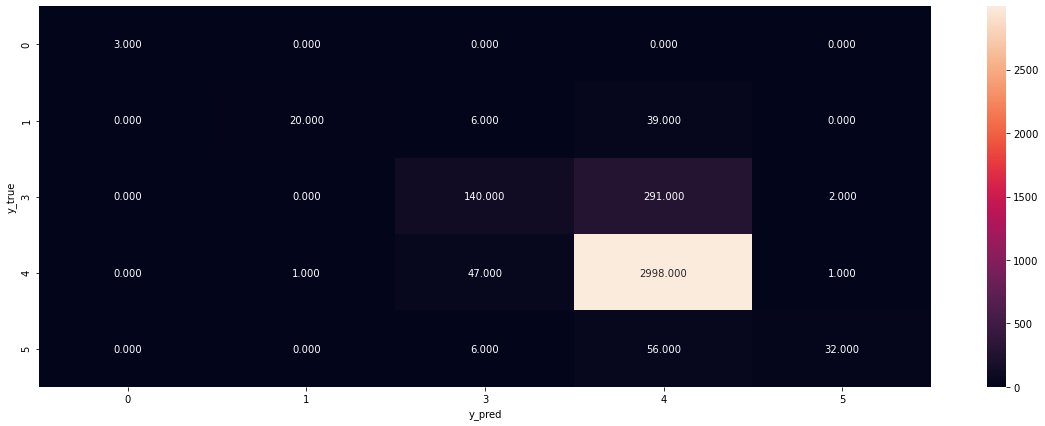

******************************
Precision matrix


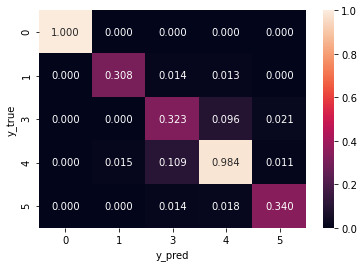

******************************
Recall matrix


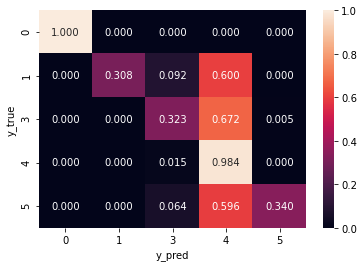

In [13]:
#plot the confusion on test data
pred=sig_clf.predict(x_test.drop(["popularity"],axis=1))
confusion_plot(y_test,pred)

In [38]:
#Creating the final model 


,Store_Ratio,Basket_Ratio,Category_1,Store_Score,Category_2,Store_Presence,Score_1,Score_2,Score_3,Score_4,time,popularity,total_score
0,0.407,0.00380,2,-35.865,1,0.9920,0.944000,0.0988,0.1100,113.911,189125,4,115.063800
1,0.234,0.10500,0,-19.884,1,0.9440,0.900000,0.1290,0.0382,76.332,186513,4,77.399200
2,0.668,0.72600,9,-7.512,1,0.0387,0.000000,0.1340,0.4530,124.075,172143,4,124.662000
3,0.184,0.00561,4,-34.357,1,0.8490,0.931000,0.1110,0.0641,79.037,184000,5,80.143100
4,0.231,0.13100,6,-22.842,1,0.9370,0.000000,0.1090,0.0677,109.560,186507,3,109.736700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18203,0.403,0.28100,6,-10.365,0,0.4540,0.000000,0.1060,0.1820,112.881,232880,4,113.169000
18204,0.481,0.01140,4,-26.196,1,0.9910,0.967000,0.0985,0.3430,57.748,155500,4,59.156500
18205,0.168,0.00908,5,-33.966,0,0.9470,0.946000,0.1250,0.3960,68.775,172500,4,70.242000
18206,0.598,0.65800,1,-7.159,0,0.3890,0.000000,0.5820,0.4730,106.807,152558,4,107.862000


In [40]:
#predicting with best hyperparameter
clf=RandomForestClassifier(n_estimators=1100,max_depth=45,class_weight='balanced',random_state=1,n_jobs=-1)
clf.fit(new_data.drop(["popularity"],axis=1),new_data["popularity"])
sig_clf=CalibratedClassifierCV(clf)
sig_clf.fit(new_data.drop(["popularity"],axis=1),new_data["popularity"])
pred=sig_clf.predict_proba(new_data.drop(["popularity"],axis=1))
print("loss of test",metrics.log_loss(new_data["popularity"],pred))


loss of test 0.08952012214342818


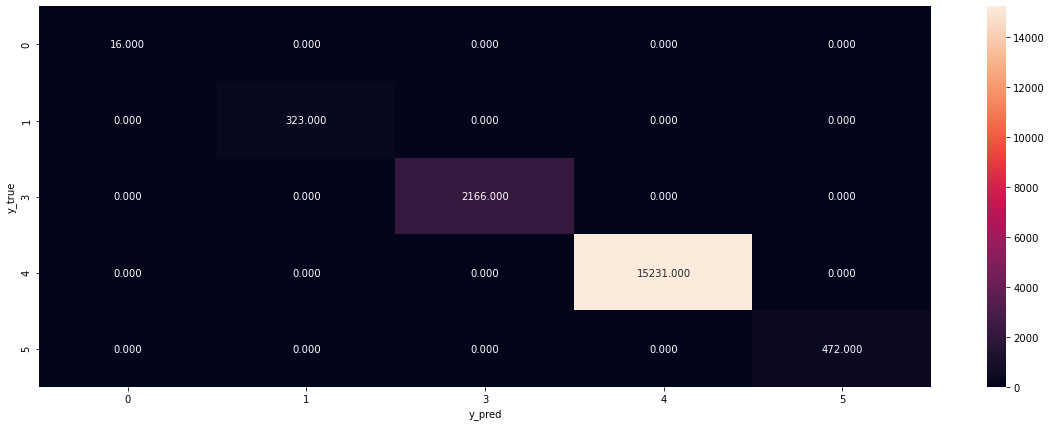

******************************
Precision matrix


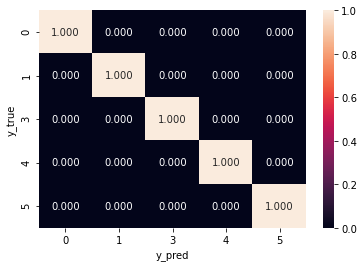

******************************
Recall matrix


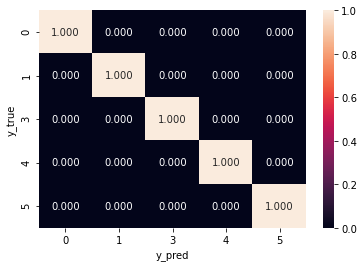

In [41]:
#plot the confusion 
pred=sig_clf.predict(new_data.drop(["popularity"],axis=1))
confusion_plot(new_data["popularity"],pred)